# Multilabel algorithms over Kunisch P.  
## Seminario de Tesis I, Primavera 2022 
### MDS Program. University of Chile.
#### Supervisor: Prof. Benjamín Bustos, Prof. Iván Sipirán
#### Author: Matías Vergara

### References:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

## Mounting Google Drive



In [53]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    folder_path = 'drive/MyDrive/TesisMV/'
except:
    folder_path = '../'

In [54]:
import os
os.listdir(folder_path)

['.git',
 '.gitignore',
 '.idea',
 'actas',
 'features',
 'graficos',
 'labels',
 'models',
 'notebooks',
 'patterns',
 'presentaciones',
 'README.md',
 'requirements.txt']

## Define flags

In [55]:
#modify only this cell
USE_RN50 = False
DS_FLAGS = ['crop', 'elastic', 'rain']
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 2
ELASTIC_TIMES = 3

In [56]:
# This cells builds the data_flags variable, that will be used
# to map the reques data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

labels_path = folder_path + "labels/" + data_flags + '/'
data_flags = f'resnet50_{data_flags}' if USE_RN50 else f'resnet18_{data_flags}'
features_path = folder_path + "features/" + data_flags + '/'

if not (os.path.isdir(features_path) and os.path.isdir(labels_path)):
    raise FileNotFoundError("No existen directorios de datos para el conjunto de flags seleccionado. Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation\n{}\n{}".format(features_path, labels_path))
print("Pattern set encontrado en {}".format(features_path))
print("Labels set encontrado en {}".format(labels_path))

Pattern set encontrado en ../features/resnet18_rain_crop1_elastic3/
Labels set encontrado en ../labels/rain_crop1_elastic3/


In [57]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [58]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from scipy import sparse

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing

In [59]:
features_train = pd.read_json(features_path + train_filename, orient='index').sort_index()
features_val = pd.read_json(features_path + val_filename, orient='index').sort_index()
features_test = pd.read_json(features_path + test_filename, orient='index').sort_index()

In [60]:
features_train

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
10a,0.133635,3.186670,4.207080,1.745902,0.184138,0.049078,0.070386,0.001361,1.039203,0.000520,...,0.483960,0.249826,0.023943,0.112353,1.350718,0.040253,0.229161,0.116383,1.129545,5.147801
10a_crop0,0.127906,1.221447,2.797734,1.781329,0.025777,0.004466,0.018766,0.013151,1.384300,0.000000,...,0.237791,0.370732,0.027279,0.009646,1.170290,0.006930,0.041464,0.030989,0.490693,2.696245
10a_crop1,0.078160,0.101466,0.869786,0.851161,0.000000,0.004177,0.000000,0.406904,0.872731,0.019547,...,0.048695,0.240046,0.245777,0.021586,0.548606,0.002188,0.000194,0.010910,0.100278,0.414523
10a_elastic2,0.078565,2.064913,2.750678,1.205837,0.037120,0.027109,0.034031,0.101080,1.277952,0.000000,...,0.178816,0.380159,0.264856,0.107775,0.906188,0.016858,0.067730,0.125277,1.063994,2.947588
10a_elastic3,0.158400,3.156503,4.029147,1.151180,0.059914,0.000000,0.000000,0.011300,0.643933,0.002853,...,0.320456,0.355615,0.013886,0.113173,0.909881,0.000000,0.101440,0.219998,1.049216,4.717736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9d_crop0,0.251528,2.718696,3.575315,3.446563,1.160666,0.826861,0.856984,0.257198,1.866296,0.003856,...,1.356668,0.198179,0.639939,0.039901,2.477602,0.724612,1.126866,0.033034,0.812844,4.690364
9d_crop1,0.253098,1.880994,3.028223,2.776139,0.807189,0.576669,0.586685,0.283782,1.429421,0.023031,...,0.964157,0.134693,0.511445,0.012511,2.027840,0.458706,0.808268,0.000000,0.737976,3.951941
9d_elastic2,0.116133,1.427291,2.231390,1.783792,0.335871,0.215351,0.212530,0.628935,1.125090,0.110368,...,0.394294,0.104766,0.568864,0.026841,1.014692,0.184833,0.323428,0.002909,0.584926,2.782768
9d_elastic3,0.186606,1.847843,2.852705,3.236686,0.759142,0.494497,0.532409,0.463887,1.619140,0.065420,...,0.912652,0.087560,0.767435,0.008321,2.008330,0.496401,0.757711,0.002588,0.654255,3.918101


In [61]:
features_val

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
10e,0.058697,1.771700,1.964076,0.024035,0.004108,0.129747,0.000142,1.280835,1.183648,0.884516,...,0.015396,0.594275,0.589192,0.269900,0.017756,0.036844,0.000000,1.118273,0.967680,0.688162
11h,0.077705,1.727675,1.181132,0.274260,0.029754,0.053216,0.000000,1.312236,0.857839,0.963223,...,0.083732,0.583189,0.582433,0.348565,0.139031,0.046938,0.044963,1.171220,0.711182,0.401116
12d,0.144626,2.490133,2.088905,0.249197,0.068724,0.076544,0.013665,1.468301,1.867169,0.830531,...,0.062144,0.654816,0.790378,0.363395,0.043629,0.043695,0.025914,1.443702,1.347237,1.426574
13b,0.049530,2.450509,2.279142,0.010265,0.024446,0.025683,0.009089,1.362492,1.472301,0.705835,...,0.026001,0.553604,0.878311,0.048584,0.000774,0.015553,0.000412,0.601309,1.018246,0.670997
14a,0.134624,2.221929,1.982430,0.584371,0.037964,0.072659,0.005479,1.708380,1.985331,1.208047,...,0.021993,0.848055,0.832749,0.262130,0.011182,0.065503,0.002404,1.410545,1.222741,0.947545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94e,0.054193,0.313573,0.441224,0.938808,0.057569,0.046502,0.052694,0.531004,0.644327,0.424139,...,0.093744,0.159639,0.846922,0.017928,0.648983,0.042620,0.078110,0.015677,0.336920,0.515712
95d,0.017270,0.832141,1.298416,0.088627,0.001058,0.039904,0.000000,0.173996,0.353254,0.071324,...,0.005614,0.075104,0.079045,0.649887,0.225704,0.011445,0.001142,0.977175,0.336476,1.655241
95g,0.031608,0.242156,0.559034,0.023804,0.000152,0.042495,0.000340,0.147422,0.210229,0.109598,...,0.030840,0.044209,0.031165,0.855009,0.333922,0.000000,0.002136,1.036529,0.166817,1.620800
96i,0.035035,1.846944,2.291114,0.344958,0.002924,0.003364,0.000000,0.039779,0.146000,0.006781,...,0.041053,0.178790,0.010808,0.638654,0.430545,0.000000,0.016589,1.074504,0.484619,2.583478


In [62]:
features_test

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
12b,0.117958,2.477953,2.122522,0.015607,0.009214,0.093248,0.000000,1.415253,1.298121,0.791522,...,0.037746,0.483232,1.080020,0.589332,0.008039,0.012026,0.002985,1.543718,1.120886,1.635633
13d,0.186491,1.928133,1.692774,0.400295,0.019230,0.068343,0.000000,0.814242,1.703326,0.657584,...,0.024312,0.653083,0.355718,0.757933,0.008980,0.026673,0.004517,1.949570,1.152744,1.924549
16l,0.063684,1.541434,1.489950,0.120193,0.021468,0.029332,0.000000,1.470590,1.177786,0.781952,...,0.021504,0.582529,1.090538,0.157282,0.021350,0.041717,0.002915,0.653804,0.822334,0.810368
16m,0.177181,1.996373,1.666471,0.362351,0.096416,0.208963,0.000000,1.548831,1.345820,1.074336,...,0.019794,0.830451,0.428060,0.678568,0.005241,0.100421,0.014203,2.079086,1.182116,1.204779
18e,0.109140,2.946646,1.989637,0.349439,0.098043,0.207322,0.000000,2.230519,1.158798,1.774637,...,0.028834,0.904997,0.919107,0.971085,0.025583,0.247505,0.042829,2.733816,1.438804,1.141191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85i,0.051679,0.227490,0.009059,4.250698,2.567595,2.229537,2.612629,0.838407,0.775844,0.762022,...,2.853502,0.154440,1.347574,0.173431,4.301222,2.474586,1.857526,0.100932,0.303853,0.114269
87a,0.135469,1.130161,0.107941,7.607179,5.350328,4.640768,5.433270,0.640926,1.278817,0.558602,...,6.218578,0.221888,1.991057,0.320782,8.388741,5.028416,3.915829,0.305386,0.364839,0.610055
88c,0.116107,0.617550,0.025672,7.861081,5.606524,4.889144,5.742307,0.296600,1.336751,0.399997,...,6.306037,0.011180,2.373047,0.214063,8.345397,5.324197,4.009048,0.172866,0.294526,0.300085
89f,0.059243,0.141449,0.078649,2.660661,1.536557,1.397114,1.656830,0.486583,0.492788,0.385682,...,1.714952,0.101562,1.087637,0.131735,2.755788,1.440563,1.116171,0.072301,0.172494,0.098422


In [63]:
labels_train = pd.read_json(labels_path + train_filename, orient='index').sort_index()
labels_val = pd.read_json(labels_path + val_filename, orient='index').sort_index()
labels_test = pd.read_json(labels_path + test_filename, orient='index').sort_index()

In [64]:
labels_train

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10a,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10a_crop0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10a_crop1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10a_elastic2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10a_elastic3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9d_crop0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9d_crop1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9d_elastic2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9d_elastic3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
labels_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10e,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11h,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12d,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94e,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
95d,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
95g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
96i,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
labels_test

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
12b,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13d,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
16l,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16m,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85i,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
87a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89f,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [67]:
def filter_labels(labels_df, freq):
  """Filters a label dataframe based on labels frequency (number of events)

    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > freq]
  top_labels = filtered_df.sum().sort_values(ascending=False)
  return top_labels

def filter_dfs(df, top_labels_df):
  df = df[df.columns.intersection(top_labels_df.index)]
  return df

def combine_dfs(labels_df, top_labels_df, features_df):
  """Combine labels dataframe with features dataframe based on index (patterns names)
     keeping only the most frequent labels.

    Parameters:
    labels_df (DataFrame): dataframe of labels, with patterns name as index
    top_labels_df (DataFrame): a 1D dataframe with the name of the most freq. labels, as 
    the outcome of filter_labels() function 
    features_df (DataFrame): dataframe of features, with patterns name as index 

    Returns:
    DataFrame: combined labels + features dataframe, merged on index

  """
  assert len(labels_df) == len(features_df)
  labels_df = labels_df[labels_df.columns.intersection(top_labels_df.index)]
  final_df = pd.merge(labels_df,       
                      features_df,  
                      left_index=True, right_index=True)
  return final_df

def split_data(final_df, top_labels_df, test_size):
  """Splits the data in train and test. 
    
    Parameters:
    final_df (DataFrame): outcome of combine_dfs.
    top_labels_df (DataFrame): dataframe of most freq. labels. Necessary to 
    know at which column the labels (Y) ends and the features (X) starts  
    freq (int): threshold frequency. Labels with a lower value will be filtered. 
    test_size (float): proportion test/(test+train).

    Returns:
    (np.array, np.array, np.array, np.array): X train, X test, Y train, Y test

  """
  X = np.array(final_df.iloc[:, len(final_df):], dtype=float)
  Y = np.array(final_df.iloc[:, 0:len(final_df)], dtype=float)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,random_state=42)
  return X_train, X_test, Y_train, Y_test

In [68]:
top_labels_df = filter_labels(labels_train, 180) # for example
top_labels_df

panel            2094
horizontal       1698
ornament          822
vertical          756
hatched           732
metopal           600
lozenge           600
filling           570
double            432
triangle          426
cross-hatched     396
meander           342
circle            330
chain             324
bar               306
concentric        288
enclosing         282
line              258
dotted            252
outline           240
single            216
hook              216
zigzag            210
solid             210
cross             192
dot               186
dtype: int64

# Data exploration

In [69]:
def get_unique_combinations(labels_df):
  """Returns the number of different combinations of labels in labels_df.

    Parameters:
    labels_df (DataFrame): dataframe of labels 

    Returns:
    int: number of unique labels combinations in labels_df
  """
  unique_combinations = len(labels_df.drop_duplicates())
  print("Number of unique labels combinations: " + str(unique_combinations))
  return unique_combinations

def get_label_metrics(labels_df):
  """Returns label cardinality and label density of a multilabel dataset.
     Label cardinality: average number of labels per entry 
     Label density: fraction of assigned labels over total num of labels,
                    averaged per entry
    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  sum_labels = labels_df.sum(axis=1)
  total_labels = labels_df.shape[0]
  label_cardinality = 0
  for label in sum_labels:
    label_cardinality += label/total_labels
  label_density = label_cardinality/total_labels
  print("Label cardinality: {}".format(label_cardinality))
  print("Label density: {}".format(label_density))
  return(label_cardinality, label_density)

print("Exploring train set")
combinations = get_unique_combinations(labels_train)
metrics = get_label_metrics(labels_train)

Exploring train set
Number of unique labels combinations: 480
Label cardinality: 5.37903225806449
Label density: 0.0014459764134581964


# Functions to run experiments and visualizations

In [70]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [71]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    clf_predictions = sparse.csr_matrix(clf_predictions)
    exact_match = accuracy_score(ytest,clf_predictions)
    ham_loss = hamming_loss(ytest,clf_predictions)
    ham_score = hamming_score(ytest.toarray(), clf_predictions.toarray())
    result = {"exact_match":exact_match,"hamming_loss": ham_loss, "hamming_score":ham_score}
    return result, clf_predictions

In [72]:
# Plotting linemarks
ALREADY_RUN = False 

# This code has to be executed only once in order to have the same linemarks in 
# each figure
if not ALREADY_RUN:
  import random
  linemark = []
  MARKERS = ['.','+','v','x','*']
  LINE_STYLES = ['-','--','-.',':']

  for i in range(0, 20): 
    linestyle = LINE_STYLES[random.randint(0, len(LINE_STYLES)-1)]
    marker = MARKERS[random.randint(0, len(MARKERS)-1)]
    linemark.append (linestyle + marker)
  
  ALREADY_RUN = True

In [73]:
  def plot_results(x, acc = [], loss = [], score=[], label=[], title = "",
                 xlabel = "", ylabel = "", plot_emr=False, plot_hl=False, plot_hs=True):
    """plots accuracy, hamming loss and hamming score of multiple classifiers.
    
    Returns:
    DataFrame: filtered labels dataframe

    """
    assert len(acc) == len(loss) == len(label)
    if plot_emr:
        f_acc = plt.figure(1)
        f_acc.set_figheight(9)
        f_acc.set_figwidth(7)
        ax1 = f_acc.add_subplot(111)
        ax1.set_title(title + "\n Exact Match Ratio")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_ylim(0, 1)
        for i in range(0, len(acc)):
          ax1.plot(x, acc[i],  linemark[i], label=label[i])
        ax1.legend()
        f_acc.show()
    if plot_hl:
        f_loss = plt.figure(2)
        f_loss.set_figheight(9)
        f_loss.set_figwidth(7)
        ax2 = f_loss.add_subplot(111)
        ax2.set_title(title  + "\n Hamming Loss")
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel(ylabel)
        for i in range(0, len(loss)):
          ax2.plot(x, loss[i], linemark[i], label=label[i])
        ax2.legend()
        f_loss.show()

    if plot_hs:
        f_score = plt.figure(3)
        f_score.set_figheight(9)
        f_score.set_figwidth(7)
        ax3 = f_score.add_subplot(111)
        ax3.set_title(title  + "\n Hamming Score")
        ax3.set_xlabel(xlabel)
        ax3.set_ylabel(ylabel)
        ax3.set_ylim(0, 1)
        for i in range(0, len(score)):
          ax3.plot(x, score[i], linemark[i], label=label[i])
        ax3.legend()
        f_score.show()

In [74]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    """
    Prints confusion matrix for multilabel classification.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

def plot_multiple_matrix(cfs_matrix, present_labels, nrows=24, ncols=5, figsize=(12,50), filename="results"):
  """
  Plots multiple confusion matrix

  Parameters:
  cfs_matrix (2D array): an array containing the multiple confusion matrix as
                         outcome of multilabel_confusion_matrix()
  present_labels (1D array): array of strings with name of labels, in the same
                             order as they are in cfs_matrix
  nrows, ncols, figsize: number of rows, columns and size of the plot
  
  """
  fig, ax = plt.subplots(24, 5, figsize=(12, 50))

  for axes, cfs_vals, label in zip(ax.flatten(), cfs_matrix, present_labels):
      print_confusion_matrix(cfs_vals, axes, label, ["N", "Y"])

  fig.tight_layout()
  plt.show()
  plt.savefig(filename + ".png")

# Benchmark


In [81]:
#MIN_FREQS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
#            26, 30, 34, 38, 40, 50, 60, 80, 100]
#MIN_FREQS = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
MIN_FREQS = [120, 180, 220]

TRANSF_METHODS = {"BR": BinaryRelevance, "LP": LabelPowerset,
                  "CC": ClassifierChain, "RakelD": RakelD}
mlknn = MLkNN(k=1, s=1)
mltsvm = MLTSVM(c_k=4)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {"MLkNN": mlknn} #, "MLTSVM": mltsvm, "BRkNN": brknna}
BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'),
                    "SVC": svm.SVC()}#, "DT": tree.DecisionTreeClassifier()} # "GNB": GaussianNB()
exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss [meth_name + "_" + base_name] = []

for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss [meth_name] = []

for i in MIN_FREQS:
  print("Starting with i={}".format(i))
  # Dataset creation
  top_labels_i = filter_labels(labels_train, i)
  X_train = features_train
  X_test = features_test
  Y_train = filter_dfs(labels_train, top_labels_i) # reduce labels to most freq
  Y_test = filter_dfs(labels_test, top_labels_i) # in both train and test

  for meth_name, method in ADAPT_METHODS.items():
    output_i, predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
    exp_exact_match[meth_name].append(output_i['exact_match'])
    exp_hscore[meth_name].append(output_i['hamming_score'])
    exp_hloss[meth_name].append(output_i['hamming_loss'])

  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
    for base_name, classifier in BASE_CLASSIFIERS.items():
      output_i, _ = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
      exp_exact_match[meth_name + "_" + base_name].append(output_i['exact_match'])
      exp_hscore[meth_name + "_" + base_name].append(output_i['hamming_score'])
      exp_hloss[meth_name + "_" + base_name].append(output_i['hamming_loss'])


Starting with i=120
Starting with i=180


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


Starting with i=220


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


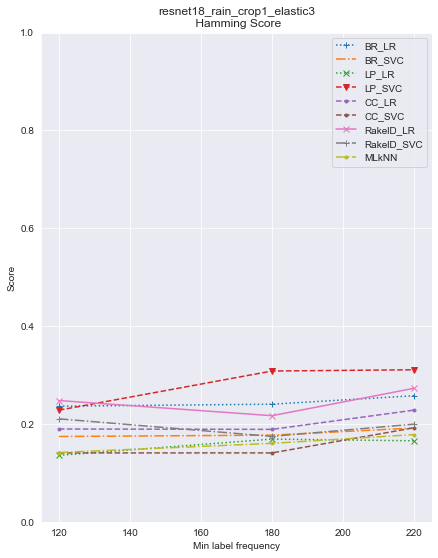

In [82]:
plot_results(MIN_FREQS,
             acc = list(exp_exact_match.values()),
             loss = list(exp_hloss.values()),
             score = list(exp_hscore.values()),
             label= list(exp_exact_match.keys()),
             title = data_flags,
            xlabel = "Min label frequency", ylabel = "Score")

# Best model at a given threshold

In [119]:
THRESHOLD = 180
METHOD = "LP" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "SVC" # | "SVC" | "DT" | "GNB" | "LR"

top_labels = filter_labels(labels_train, THRESHOLD)
print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test
Y_test = filter_dfs(labels_test, top_labels)


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

print(data_flags)
print("HAMMING SCORE: {}".format(clf_model['hamming_score']))
predictions = predictions.toarray()
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test, 
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

ATTENTION: TESTING WITH 26 LABELS
resnet18_rain_crop1_elastic3
HAMMING SCORE: 0.3081908831908832
               precision    recall  f1-score   support

        panel       0.48      0.87      0.62        31
   horizontal       0.62      0.93      0.74        40
     ornament       0.25      0.18      0.21        11
     vertical       0.00      0.00      0.00         1
      hatched       0.00      0.00      0.00         2
      metopal       0.00      0.00      0.00         3
      lozenge       0.00      0.00      0.00        15
      filling       0.00      0.00      0.00        10
       double       0.00      0.00      0.00         1
     triangle       0.19      0.33      0.24         9
cross-hatched       0.35      0.29      0.32        21
      meander       0.00      0.00      0.00         1
       circle       0.00      0.00      0.00        12
        chain       0.00      0.00      0.00         4
          bar       0.00      0.00      0.00         0
   concentric       0.

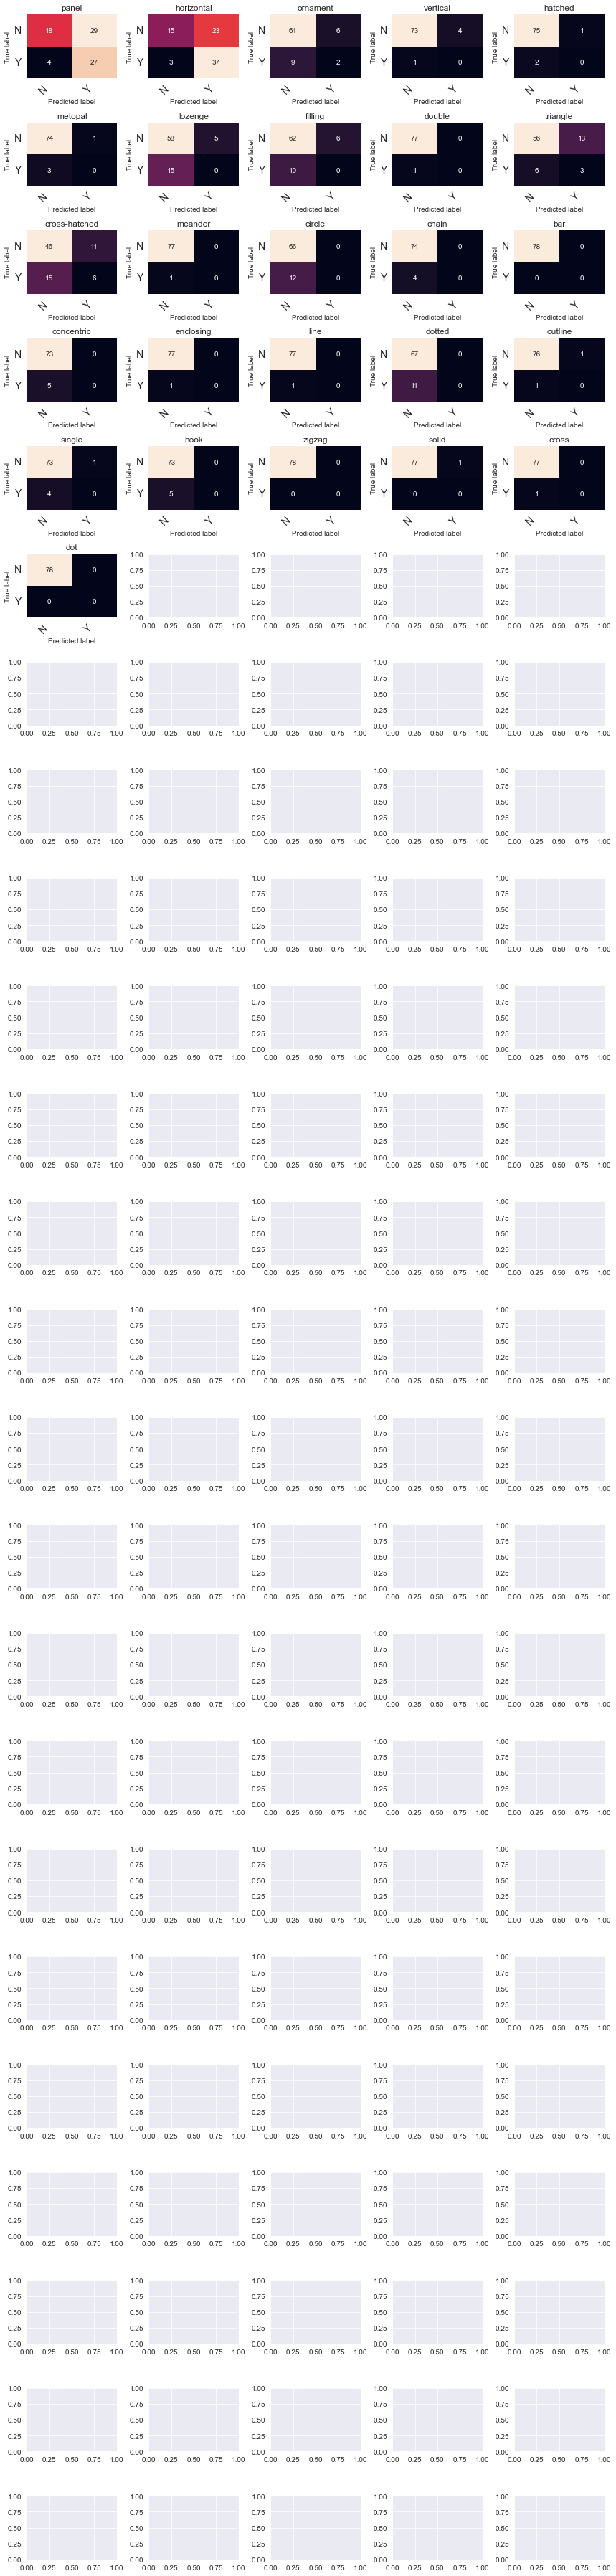

<Figure size 432x288 with 0 Axes>

In [120]:
plot_multiple_matrix(cfs_matrix, present_labels)

# Binary Relevance with handcrafted class balance

In [116]:
def split_balanced(label, columns, X_train, Y_train):
  """Generates a balanced train and test dataset for a given label
    ATTENTION: MODIFIED TO ADD ONLY ORIGINAL PATTERNS TO THE NEGATIVE DATASET

    Parameters:
    label (String): label with which the balanced dataset will be created
    colnames (1D array):
    X_train, Y_train (dataFrames): original (potentially unbalanced) train datasets.

    Returns:
    X_train, Y_train (dataFrames): train datasets with equal number of positive and
                                  negative events for the given label. 

  """
  index_label = columns.tolist().index(label)
  indexes_positives = []
  indexes_negatives = []

  i=0
  for index, row in Y_train.iterrows():
    if row.values[index_label] == 1:
      indexes_positives.append(i)
    elif "_" not in index:
      indexes_negatives.append(i)
    i+=1
  indexes_negatives = indexes_negatives[0:len(indexes_positives)]
  final_indexes = indexes_positives + indexes_negatives
  final_indexes.sort()
  X_train = X_train.values[final_indexes, :]
  Y_train = Y_train.values[final_indexes, index_label]
  return X_train, Y_train

In [117]:
base_classifiers = {}
THRESHOLD = 180

top_labels = filter_labels(labels_train, THRESHOLD)
print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test
Y_test = filter_dfs(labels_test, top_labels)
columns = Y_test.columns
predictions = []

for i in range(0, len(top_labels)):
  label = columns[i]
  bc = LogisticRegression(solver='lbfgs')
  X_train_label, Y_train_label = split_balanced(label, columns, X_train, Y_train) # tantos positivos como posible e igual a negativos
  bc.fit(X_train_label, Y_train_label)
  base_classifiers[label] = bc
  clf_prediction = bc.predict(X_test.values)
  predictions.append(clf_prediction) # una columna de prediccion

predictions = np.array(predictions).T

exact_match = accuracy_score(Y_test.values, predictions)
ham_loss = hamming_loss(Y_test.values, predictions)
ham_score = hamming_score(Y_test.values, predictions)

#print("Exact match ratio: {}".format(exact_match))
#print("Hamming loss: {}".format(ham_loss))
print("Hamming score: {}".format(ham_score))

ATTENTION: TESTING WITH 26 LABELS
Hamming score: 0.16061370482014112


In [ ]:
present_labels = top_labels.index
cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test, 
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

In [ ]:
plot_multiple_matrix(cfs_matrix, present_labels)